# Practical Application III: Comparing Classifiers -- #2

### Problem 11: Improving the Model (2 of 2)

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import time
from random import shuffle
from sklearn.metrics import roc_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.metrics import accuracy_score, precision_score,recall_score, classification_report, mean_squared_error, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Encode the data**

In [9]:
def ordinal_encode_df(df):
    enc = OrdinalEncoder()
    enc.fit(df)
    return enc.transform(df)

# X encoded
ordinal_values = ordinal_encode_df(df.drop(columns=['y']))
df_o_transformed = pd.DataFrame(ordinal_values, columns=df.columns[0:-1])

def label_encode(df):
    le = LabelEncoder()
    le.fit(df)
    return le.transform(df)

# y encoded
label_values = label_encode(df['y'])
df_l_transformed = pd.DataFrame(label_values, columns=['y'])

In [18]:
X = df_o_transformed # 41188, 20
y = df_l_transformed['y'] # 41188,

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# (27595, 20) (13593, 20) (27595,) (13593,)

In [43]:
feature_selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward', scoring="balanced_accuracy", tol=0.01, cv=5)
feature_selector.fit_transform(X_train, y_train)
feature_selector.get_feature_names_out()

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m'], dtype=object)

In [44]:
feature_selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward', scoring="recall", tol=0.01, cv=5)
feature_selector.fit_transform(X_train, y_train)
feature_selector.get_feature_names_out()

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m'], dtype=object)

In [195]:
df_o_transformed['nr.employed'].value_counts()

10.0    16234
6.0      8534
8.0      7763
9.0      3683
5.0      1663
3.0      1071
1.0       773
2.0       650
0.0       635
4.0       172
7.0        10
Name: nr.employed, dtype: int64

In [46]:
df_o_transformed.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

**From the two SequentialFeatureSelector, it can be seen that only the 'nr.employed' is omitted**

In [241]:
X = df_o_transformed.drop(columns=['nr.employed'])
y = df_l_transformed['y']

X.shape, y.shape

((41188, 19), (41188,))

In [242]:
counter = Counter(y)
print(counter)

Counter({0: 36548, 1: 4640})


In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Hyperparameter tuning and grid search. All of our models have additional hyperparameters to tune and explore. For example the number of neighbors in KNN or the maximum depth of a Decision Tree.

In [80]:
def run_grid_search_return_cs_results(pipeline, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(pipeline, params, return_train_score=True, cv=5).fit(X_train, y_train)
    grid_score = grid.score(X_test, y_test)
    return grid.cv_results_, grid.best_params_, grid_score

In [81]:
def score_model(model, X, y, X_train, y_train, X_test, y_test, pos_label):
    scoring_dict = {}
    
    fit_start = time.time()
    model.fit(X_train, y_train)
    scoring_dict['fit_time'] = time.time() - fit_start
    
    cv_result = cross_validate(model, X, y, return_train_score=True, cv=5)
    scoring_dict['training_accuracy'] = cv_result['train_score'].mean()
    
    y_pred = model.predict(X_test)
    scoring_dict['test_accuracy'] = accuracy_score(y_test, y_pred)

#     scoring_dict['accuracy'] = accuracy_score(y_test, y_pred)
    scoring_dict['precision'] = precision_score(y_test, y_pred, pos_label=pos_label)
    scoring_dict['recall'] = recall_score(y_test, y_pred, pos_label=pos_label)
    scoring_dict['f1'] = f1_score(y_test, y_pred, pos_label=pos_label)
    
    return scoring_dict

In [82]:
# LogisticRegression: find best params
params = {
    'lr__max_iter':np.arange(100,200), 
    'lr__solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga']
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])
cv_results_lr_accuracy, best_params, score = run_grid_search_return_cs_results(pipeline, params, X_train, y_train, X_test, y_test)

lr_grid_search_dict = {}

tr = cv_results_lr_accuracy['mean_train_score']
lr_grid_search_dict['train_score'] = tr[~np.isnan(tr)].mean()

ts = cv_results_lr_accuracy['mean_test_score']
lr_grid_search_dict['test_score'] = ts[~np.isnan(ts)].mean()

lr_grid_search_dict['avg_fit_time'] = cv_results_lr_accuracy['mean_fit_time'].mean()
lr_grid_search_dict['best_max_iter'] = best_params['lr__max_iter']
lr_grid_search_dict['best_solver'] = best_params['lr__solver']

print('--- LogisticRegression Grid Search:')
lr_grid_search_dict

--- LogisticRegression Grid Search:


{'train_score': 0.9109968593344204,
 'test_score': 0.9102856797729059,
 'avg_fit_time': 0.05247000622749328,
 'best_max_iter': 100,
 'best_solver': 'lbfgs'}

- Adjust your performance metric

In [83]:
# LogisticRegression: use best params
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=100, solver='lbfgs'))
])

scoring_dict_lr = score_model(pipeline2, X, y, X_train, y_train, X_test, y_test, 0)

print('--- LogisticRegression Scores:')
scoring_dict_lr

--- LogisticRegression Scores:


{'fit_time': 0.07808780670166016,
 'training_accuracy': 0.9191450379556088,
 'test_accuracy': 0.911351430883543,
 'accuracy': 0.911351430883543,
 'precision': 0.9290965141095565,
 'recall': 0.9744652628088211,
 'f1': 0.9512402379314531}

In [84]:
# KNeighborsClassifier: find best params
params = {'knn__n_neighbors':np.arange(1,11,2)}
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
cv_results_knn, best_params, score = run_grid_search_return_cs_results(pipeline3, params, X_train, y_train, X_test, y_test)

knn_grid_search_dict = {}

tr = cv_results_knn['mean_train_score']
knn_grid_search_dict['train_score'] = tr[~np.isnan(tr)].mean()

ts = cv_results_knn['mean_test_score']
knn_grid_search_dict['test_score'] = ts[~np.isnan(ts)].mean()

knn_grid_search_dict['avg_fit_time'] = cv_results_knn['mean_fit_time'].mean()
knn_grid_search_dict['best_k'] = best_params['knn__n_neighbors']

print('--- KNeighborsClassifier Grid Search:')
knn_grid_search_dict

--- KNeighborsClassifier Grid Search:


{'train_score': 0.9408208008697226,
 'test_score': 0.8971770248233375,
 'avg_fit_time': 0.0055844211578369145,
 'best_k': 9}

In [63]:
# KNeighborsClassifier using best params
pipeline4 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9))
])

scoring_dict_knn = score_model(pipeline4, X, y, X_train, y_train, X_test, y_test, 0)

print('--- KNeighborsClassifier Scores:')
scoring_dict_knn

--- KNeighborsClassifier Scores:


{'fit_time': 0.020617961883544922,
 'training_accuracy': 0.9320007255911189,
 'test_accuracy': 0.9025969248878098,
 'accuracy': 0.9025969248878098,
 'precision': 0.9238546603475514,
 'recall': 0.9701393497013935,
 'f1': 0.9464314614015212}

In [89]:
# DecisionTreeClassifier: find best params
params = {
    'tree__criterion':['gini', 'entropy', 'log_loss'],
    'tree__max_depth':np.arange(1,4)
}
pipeline5 = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier())
])
cv_results_tree, best_params, score = run_grid_search_return_cs_results(pipeline5, params, X_train, y_train, X_test, y_test)

tree_grid_search_dict = {}

tr = cv_results_tree['mean_train_score']
tree_grid_search_dict['train_score'] = tr[~np.isnan(tr)].mean()

ts = cv_results_tree['mean_test_score']
tree_grid_search_dict['test_score'] = ts[~np.isnan(ts)].mean()

tree_grid_search_dict['avg_fit_time'] = cv_results_tree['mean_fit_time'].mean()
tree_grid_search_dict['best_criterion'] = best_params['tree__criterion']
tree_grid_search_dict['best_max_depth'] = best_params['tree__max_depth']

print('--- DecisionTreeClassifier Grid Search:')
tree_grid_search_dict

--- DecisionTreeClassifier Grid Search:


{'train_score': 0.8965935857945281,
 'test_score': 0.8953715447645507,
 'avg_fit_time': 0.017237642076280382,
 'best_criterion': 'gini',
 'best_max_depth': 3}

In [90]:
# DecisionTreeClassifier using best params
pipeline6 = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=3))
])

scoring_dict_tree = score_model(pipeline6, X, y, X_train, y_train, X_test, y_test, 0)

print('--- DecisionTreeClassifier Scores:')
scoring_dict_tree

--- DecisionTreeClassifier Scores:


{'fit_time': 0.04920816421508789,
 'training_accuracy': 0.9192178317471351,
 'test_accuracy': 0.9078202015743397,
 'accuracy': 0.9078202015743397,
 'precision': 0.9486924034869241,
 'recall': 0.9473553307909136,
 'f1': 0.9480233956941967}

In [73]:
# SVC: find best params
params = {
    'svc__C':np.arange(0.01,1,0.05),
    'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma':['scale','auto']
}
pipeline7 = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
cv_results_tree, best_params, score = run_grid_search_return_cs_results(pipeline7, params, X_train, y_train, X_test, y_test)

svc_grid_search_dict = {}

tr = cv_results_tree['mean_train_score']
svc_grid_search_dict['train_score'] = tr[~np.isnan(tr)].mean()

ts = cv_results_tree['mean_test_score']
svc_grid_search_dict['test_score'] = ts[~np.isnan(ts)].mean()

svc_grid_search_dict['avg_fit_time'] = cv_results_tree['mean_fit_time'].mean()
svc_grid_search_dict['best_c'] = best_params['svc__C']
svc_grid_search_dict['best_kernel'] = best_params['svc__kernel']
svc_grid_search_dict['best_gamma'] = best_params['svc__gamma']

print(f'--- SVC Grid Search:')
svc_grid_search_dict

--- SVC Grid Search:


{'train_score': 0.9031210930422178,
 'test_score': 0.8986988131907955,
 'avg_fit_time': 2.5838674420118335,
 'best_c': 0.8600000000000001,
 'best_kernel': 'rbf',
 'best_gamma': 'scale'}

In [126]:
# SVC using best params
pipeline8 = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=.8600000000000001, kernel='rbf', gamma='scale', probability=True))
])

scoring_dict_svc = score_model(pipeline8, X, y, X_train, y_train, X_test, y_test, 0)

print('--- SVC Scores:')
scoring_dict_svc

--- SVC Scores:


{'fit_time': 22.738797187805176,
 'training_accuracy': 0.9343497046172713,
 'test_accuracy': 0.9106893253880673,
 'accuracy': 0.9106893253880673,
 'precision': 0.9258125294394725,
 'recall': 0.9776985574531587,
 'f1': 0.9510483870967741}

In [185]:
def create_DF_from_model_results(results_list):
    cummulative_dict = {}
    for result_dict in results_list:
        for key, value in result_dict.items():
            if key in cummulative_dict:
                cummulative_dict[key].append(value)
            else:
                cummulative_dict[key] = [value]

    scoring_results = pd.DataFrame.from_dict(cummulative_dict, orient='index')
    scoring_results.columns = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','SVC']
    return scoring_results.T

In [188]:
results_list = [scoring_dict_lr, scoring_dict_knn, scoring_dict_tree, scoring_dict_svc]
scoring_results = create_DF_from_model_results(results_list)
scoring_results

,fit_time,training_accuracy,test_accuracy,accuracy,precision,recall,f1
LogisticRegression,0.078088,0.919145,0.911351,0.911351,0.929097,0.974465,0.951240
KNeighborsClassifier,0.020618,0.932001,0.902597,0.902597,0.923855,0.970139,0.946431
DecisionTreeClassifier,0.049208,0.919218,0.907820,0.907820,0.948692,0.947355,0.948023
SVC,22.738797,0.934350,0.910689,0.910689,0.925813,0.977699,0.951048


In [157]:
y_pred_prob1 = pipeline2.fit(X_train, y_train).predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

y_pred_prob2 = pipeline4.fit(X_train, y_train).predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

y_pred_prob3 = pipeline6.fit(X_train, y_train).predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = pipeline8.fit(X_train, y_train).predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

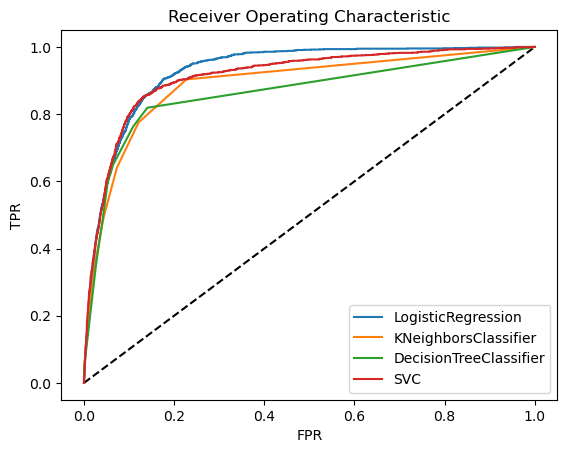

<Figure size 640x480 with 0 Axes>

In [159]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "LogisticRegression")
plt.plot(fpr2, tpr2, label= "KNeighborsClassifier")
plt.plot(fpr3, tpr3, label= "DecisionTreeClassifier")
plt.plot(fpr4, tpr4, label= "SVC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

plt.savefig("images/roc_tuned.jpg", bbox_inches='tight')

In [153]:
y_pred_lr = pipeline2.fit(X_train, y_train).predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)

y_pred_knn = pipeline4.fit(X_train, y_train).predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

y_pred_tree = pipeline6.fit(X_train, y_train).predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree)

y_pred_svc = pipeline8.fit(X_train, y_train).predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)

11793

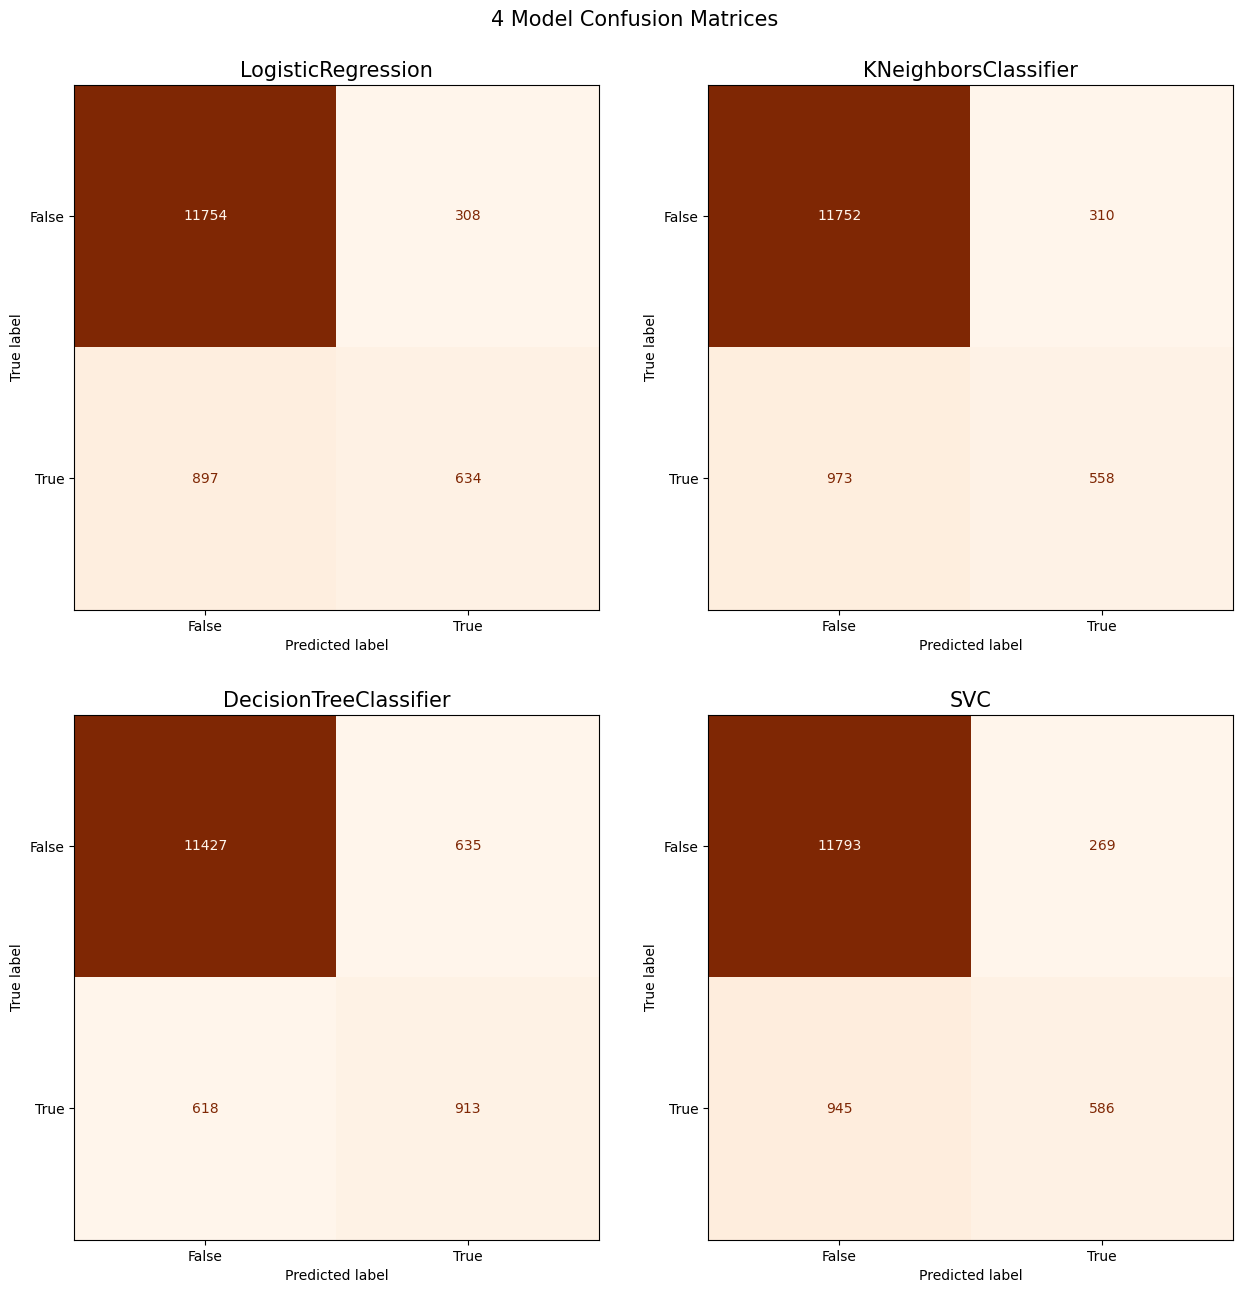

In [155]:
title_size = 15
cmap = "Oranges"
colorbar = False
# values_format = ".3f"

f, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0,0].set_title('LogisticRegression', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 0], colorbar=colorbar)

axes[0,1].set_title('KNeighborsClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar)

axes[1,0].set_title('DecisionTreeClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 0], colorbar=colorbar)

axes[1,1].set_title('SVC', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 1], colorbar=colorbar)

f.suptitle("4 Model Confusion Matrices", size=title_size, y=0.93)

plt.show()

f.savefig("images/4_model_confusion_matrices.jpg", bbox_inches='tight')

In [203]:
def calculate_cm_accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

In [199]:
def calculate_cm_precision(tp, fp):
    return tp / (tp + fp)

In [200]:
def calculate_cm_recall(tp, fn):
    return tp / (tp + fn)

In [217]:
def calculate_f1(tp, fp, fn):
    precision = calculate_cm_precision(tp, fp)
    recall = calculate_cm_recall(tp, fn)
    return 2 * (precision / recall)

In [218]:
def calculate_cm_accuracy_precision_recall(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    
    return [calculate_cm_accuracy(tp, tn, fp, fn), calculate_cm_precision(tp, fp), calculate_cm_recall(tp, fn), calculate_f1(tp, fp, fn)]

In [226]:
def calculate_scores_for_confusion_matrices(confusion_matrix_list):
    model_list = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','SVC']

    accuracy_precision_recall_f1_dict = {}
    for i in range(len(model_list)):
        accuracy_precision_recall_f1_dict[model_list[i]] = calculate_cm_accuracy_precision_recall(confusion_matrix_list[i])
    
    return accuracy_precision_recall_f1_dict

In [227]:
confusion_matrix_list = [cm_lr,cm_knn,cm_tree,cm_svc]
accuracy_precision_recall_f1_dict = calculate_scores_for_confusion_matrices(confusion_matrix_list)

df_accuracy_precision_recall = pd.DataFrame(accuracy_precision_recall_dict).T
df_accuracy_precision_recall.columns = ['Accuracy','Precision','Recall', 'F1']
df_accuracy_precision_recall

,Accuracy,Precision,Recall,F1
LogisticRegression,0.911351,0.673036,0.414108,3.250531
KNeighborsClassifier,0.905613,0.642857,0.364468,3.527650
DecisionTreeClassifier,0.907820,0.589793,0.596342,1.978036
SVC,0.910689,0.685380,0.382756,3.581287
